In [4]:
import os
from langchain_ollama import ChatOllama

# Initialize an Ollama Client for our generative Llm model

text_model = "llama3.2"

def llm_client_loader():
    """This function serves an Ollama-hosted text generator model, to be used by our graphs."""
    try:
        llm = ChatOllama(
            model=text_model,
            temperature=0.2
        )
        return llm
    except Exception as e:
        print(f"Error {e} instantiating the Ollama client, is the Ollama server running?.")

# could add something to verify Ollama is running

In [6]:
import os
import finnhub
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.graph import END
from utilities.core_utils import render_graph
from pydantic import Field, BaseModel
from typing import Literal, Any, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage

class MarketNewsProvider:
    """
    Market News Provider of a specific given category.
    """
    def __init__(
            self,
            api_key: str,
            category: Literal["general","forex","crypto", "merger"],
    ):
        self.client = finnhub.Client(api_key=api_key)
        self.category = category
        self.news_repository = self.fetch()
        self.llm_client = llm_client_loader()
        self.graph = self.graph_builder()
        self.sentiment_by_category = {"inflation":[],"rates":[],"fed":[],"macro":[], "other":[]}
        self.market_report = self.summarizer()

    def fetch(self) -> Any | None:
        try:
            if self.category:
                news_repository = self.client.general_news(category=self.category)
                return news_repository
            else:
                print(f"Missing news category parameter.")
        except Exception as e:
            print("Error fetching Market news error.", repr(e))

    def graph_builder(self) -> Any | None:
        try:
            class State(TypedDict):
                news_article: str
                sentiment: str  # result sentiment
                label: str  # result label
                bullets: str

            # Internal State definitions
            class News_Sentimenter(BaseModel):
                sentiment : Literal["positive", "negative", "neutral"] = Field(
                    description="The sentiment detected for the news article.")

            sentimenter_llm = self.llm_client.with_structured_output(News_Sentimenter)

            # Nodes / Tools
            def sentimenter(state: TypedDict):
                try:
                    """Classifier that classifies the news articles with an overall perceived sentiment.
                    """

                    # Generate queries...
                    news_articles = sentimenter_llm.invoke(
                        [
                            SystemMessage(
                                content="You are a Sentiment Analysis expert. Classify the following news article, "
                                        "assess the overall sentiment and categorize accordingly."),
                            HumanMessage(
                                content=f"News article: {state["news_article"]}."),
                        ]
                    )

                    return {"sentiment": news_articles.sentiment}

                except Exception as e:
                    print(f"Error {e} during the classifier process.")

            # Internal State definitions
            class News_Categorizer(BaseModel):
                label: Literal["inflation", "rates", "fed", "macro", "other"] = Field(
                    description="The category that resembles the news article the most.")

            categorizer_llm = self.llm_client.with_structured_output(News_Categorizer)

            # Nodes / Tools
            def categorizer(state: TypedDict):
                try:
                    """Classifier that classifies the news articles with a news category.
                    """

                    # Generate queries...
                    news_articles = categorizer_llm.invoke(
                        [
                            SystemMessage(
                                content="You are a News Categorization expert. Classify the following news article, "
                                        "accordingly."),
                            HumanMessage(
                                content=f"News article: {state["news_article"]}."),
                        ]
                    )

                    return {"label": news_articles.label}

                except Exception as e:
                    print(f"Error {e} during the classifier process.")

            # map reduce (later)
            def synthesizer(state: TypedDict):
                """Synthesizer that summarizes the news article into a couple of bullet points."""
                try:
                    # Generate queries...
                    bullet_points = self.llm_client.invoke(
                        [
                            SystemMessage(
                                content="Provide a bullet-point summary of the main arguments in the following news "
                                        "article. Keep it concise while at the same time not losing any of the most"
                                        "important information."),
                            HumanMessage(
                                content=f"News article: {state["news_article"]}."),
                        ]
                    )

                    return {"bullets": bullet_points.content}
                except Exception as e:
                    print(f"Error {e} during the synthesizer process.")

            # Build workflow
            orchestrator_worker_builder = StateGraph(State)

            # Add the nodes
            orchestrator_worker_builder.add_node("sentimenter", sentimenter)
            orchestrator_worker_builder.add_node("categorizer", categorizer)
            orchestrator_worker_builder.add_node("synthesizer", synthesizer)

            # Add edges to connect nodes
            orchestrator_worker_builder.add_edge(START, "sentimenter")
            orchestrator_worker_builder.add_edge(START, "categorizer")
            orchestrator_worker_builder.add_edge(START, "synthesizer")
            orchestrator_worker_builder.add_edge("sentimenter", END)
            orchestrator_worker_builder.add_edge("categorizer", END)
            orchestrator_worker_builder.add_edge("synthesizer", END)

            # Compile the workflow
            graph = orchestrator_worker_builder.compile()
            render_graph(graph)
            return graph
        except Exception as e:
            print(f"Error {e} during the graph building process.")

    def summarizer(self):
        try:
            bullet_points = []

            for news in self.news_repository:
                headline = news["headline"]
                news_summary = news["summary"]
                prompt = HumanMessage(f"{headline}: {news_summary}")

                state = self.graph.invoke({"news_article": f"{prompt.content}"})

                self.sentiment_by_category[state['label']].append(state["sentiment"])
                bullet_points.append(state["bullets"])

            def group_bullets(summaries, max_summaries):
                mag = []
                current_mag = []
                for summary in summaries:
                    current_mag.append(summary)
                    if len(current_mag) >= max_summaries:
                        mag.append(current_mag)
                        current_mag = []
                if len(current_mag) > 0:
                    mag.append(current_mag)

                return mag

            buckets = group_bullets(bullet_points, 7)
            final_buckets = []

            for bucket in buckets:
                response = self.llm_client.invoke(f"The following is set of bullet-point summaries: {bucket} Take these "
                                                  f"and distill it into a consolidated bullet-point summary of the main "
                                                  f"themes. Remove the bullet points that are not relevant to the whole "
                                                  f"text. The consolidated summary cannot be more than 11 bullet points.")

                final_buckets.append(response.content)

            final_response = self.llm_client.invoke(f"The following is set of bullet-point summaries: {final_buckets} "
                                                    f"Take these and distill it into a final executive summary of the "
                                                    f"main themes, capturing the key ideas without missing critical "
                                                    f"points. Ensure the summary touches upon all of main themes "
                                                    f"found, and be sure to include important details.")

            return final_response.content

        except Exception as e:
            print(f"Error {e} during the graph building process.")

# Invoke
mn = MarketNewsProvider(category="general", api_key="ct5s8spr01qp4ur8b2bgct5s8spr01qp4ur8b2c0")
print(mn.market_report)


After analyzing the provided bullet-point summaries, I have distilled the information into a comprehensive executive summary of the main themes:

**Market Trends and Economic Outlook**

* The US economy appears stable, but concerns about potential economic trouble are being closely monitored by investors.
* Interest rates may plummet, making it essential to diversify investments beyond traditional options to maintain steady income flow.
* Tokenization has more potential to revolutionize finance than stablecoins, with the ability to enable new use cases and applications in finance.

**Technology and Innovation**

* Artificial Intelligence (AI) is being used by big banks to automate certain tasks, including hiring processes, leading to a reduction in workforce.
* AI technology is nearing a tipping point, indicating significant impact on job markets and potentially exacerbating economic downturns.
* The adoption of AI tools may incentivize skilled foreign workers to upskill or reskill due

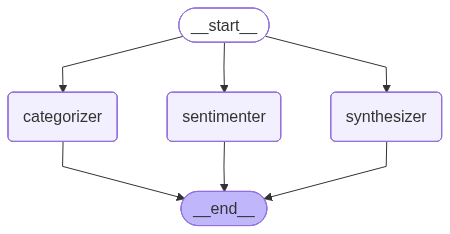

In [7]:
def _repr_mimebundle_(self, **kwargs):
    """Mime bundle used by jupyter to display the graph"""
    output = {
        "text/plain": repr(self),
        "image/png": self.get_graph().draw_mermaid_png()
        }
    return output

mn.graph._repr_mimebundle_ = _repr_mimebundle_.__get__(mn.graph)
print(mn.graph)
display(mn.graph)